In [14]:
import cudf
import cuml
from datetime import datetime
import requests
import io
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
import cupy as cp
from cuml.tsa.arima import ARIMA
import pandas as pd
from cuml.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts


In [16]:
#!wget https://raw.githubusercontent.com/rapidsai/cuml/main/notebooks/data/time_series/population_estimate.csv

--2021-07-21 23:59:26--  https://raw.githubusercontent.com/rapidsai/cuml/main/notebooks/data/time_series/population_estimate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2471 (2.4K) [text/plain]
Saving to: ‘population_estimate.csv.2’

population_estimate 100%[===================>]   2.41K  --.-KB/s    in 0s      

2021-07-21 23:59:26 (37.0 MB/s) - ‘population_estimate.csv.2’ saved [2471/2471]



In [17]:
pop = cudf.read_csv("population_estimate.csv")
print(pop.head())
pop["Year"]=pop["Year"].astype('datetime64[ns]')


   Year   Male  Female
0  1875  238.1   183.2
1  1876  250.4   194.2
2  1877  252.5   201.6
3  1878  264.6   211.5
4  1879  281.8   225.5


In [18]:
!wget "https://raw.githubusercontent.com/rapidsai/cuml/main/notebooks/data/time_series/population_estimate.csv"

--2021-07-21 23:59:27--  https://raw.githubusercontent.com/rapidsai/cuml/main/notebooks/data/time_series/population_estimate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2471 (2.4K) [text/plain]
Saving to: ‘population_estimate.csv.3’

population_estimate 100%[===================>]   2.41K  --.-KB/s    in 0s      

2021-07-21 23:59:27 (49.0 MB/s) - ‘population_estimate.csv.3’ saved [2471/2471]



In [36]:
# Load in our dataset
pop = cudf.read_csv('population_estimate.csv')

# Ask Taurean about this methodology. it was giving me the full datetime format with the year at the end
pop['Year'] = pop['Year'].to_datetime(format='%Y')

# Here is one way to convert all the items in your column to datetime, but it is cumbersome to say the least
lst = []
s = list(pop.Year.to_pandas())
for i in s:
  i = datetime.strptime(str(i), '%Y')
  lst.append(i)
pop.Year = lst
pop.info()


AttributeError: 'Series' object has no attribute 'to_datetime'

In [20]:
pop

,Year,Male,Female
0,1875-01-01,238.1,183.2
1,1876-01-01,250.4,194.2
2,1877-01-01,252.5,201.6
3,1878-01-01,264.6,211.5
4,1879-01-01,281.8,225.5
...,...,...,...
132,2007-01-01,2083.4,2169.2
133,2008-01-01,2104.1,2187.4
134,2009-01-01,2134.0,2213.2
135,2010-01-01,2158.2,2234.9


Text(0.5, 1.0, 'Population growth for men between 1875 and 2011, measured on a yearly cadence')

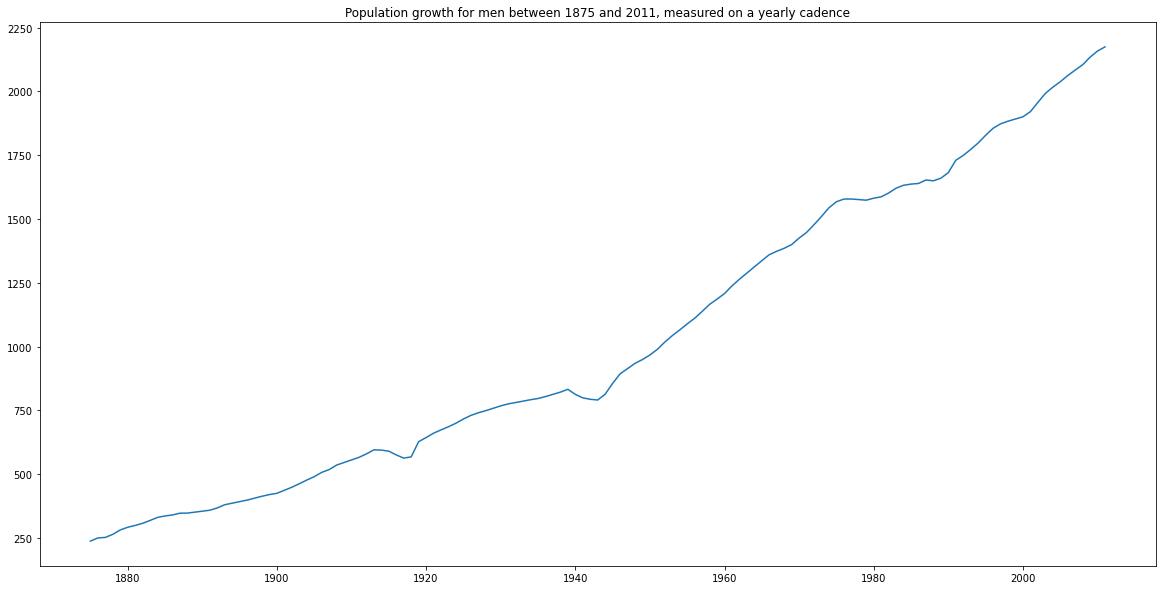

In [21]:
# Quick visualization

fig, ax = plt.subplots(figsize = (20,10))

# is there a way to not convert to pandas?
x = pop['Year'].to_pandas()
y = pop['Male'].to_pandas()
plt.plot(x,y)
ax.set_title('Population growth for men between 1875 and 2011, measured on a yearly cadence')

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


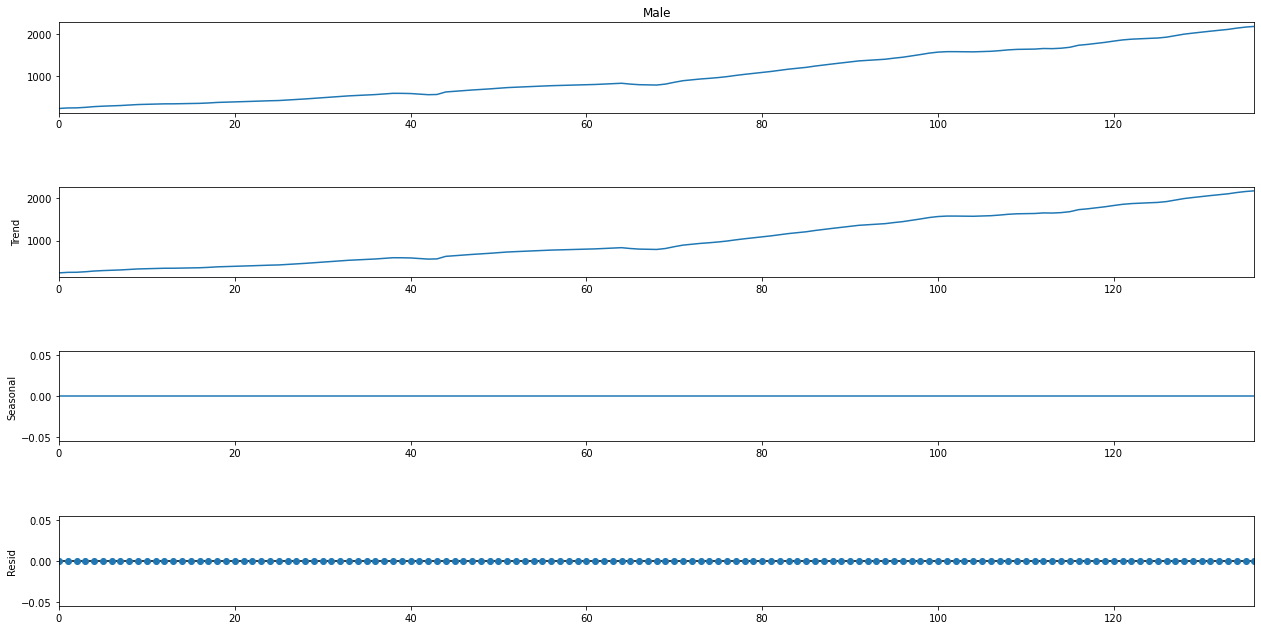

In [22]:
# lets do a seasonal decomposition to look at the trend, seasonality, and residuals
seas_d=sm.tsa.seasonal_decompose(pop['Male'].to_pandas(),model='add',freq=1);
fig=seas_d.plot()
fig.set_figheight(10)
fig.set_figwidth(20)
# it looks like this data is trending upwards

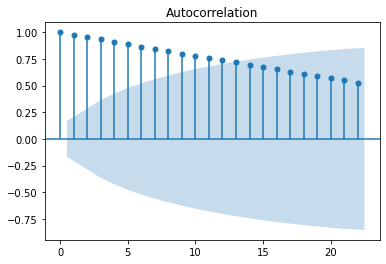

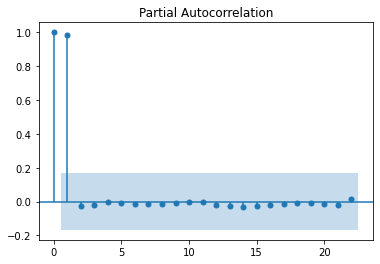

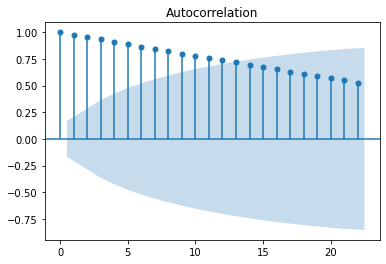

In [23]:
# use autocorrelation and partial auto correlation functions to determine ARIMA order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(y)
plot_acf(y)

In [25]:
# Test for stationarity

result = adfuller(pop['Male'].to_pandas())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.022094
p-value: 0.998701
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


In [ ]:
# lets try a log transform to try and remove the effect of stationarity
male = np.log10(pop['Male'].to_pandas().values)


result = adfuller(male)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [32]:
# Create training and test sets

train = male[:91]
test = male[91:]

In [34]:
%%time
# Fit an ARIMA(1,2,1) model
model_pop = ARIMA(train, (1,2,1), fit_intercept=True)
model_pop.fit()

# Predict in-sample and forecast out-of-sample
pred_pop = model_pop.predict(90, 136)


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass order=(1, 2, 1) as keyword args. From version 21.06, passing these as positional arguments will result in an error
  


CPU times: user 811 ms, sys: 174 ms, total: 985 ms
Wall time: 984 ms


In [35]:
# Lets check the mean squared error to see how our model does

# getting differnt values between cuml and statsmodels
cuml.metrics.regression.mean_squared_error(test, pred_pop)
# mse(test, pred_pop)

array(0.00740445)

In [37]:
df = cudf.DataFrame(columns = ['yhat', 'actual'])


df['yhat'] = [item for sublist in pred_pop for item in sublist]
df['actual'] = test
df

,yhat,actual
0,3.125278,3.133635
1,3.132818,3.137860
2,3.139114,3.141575
3,3.145151,3.146066
4,3.151039,3.153937
5,3.156827,3.160589
6,3.162541,3.169616
7,3.168190,3.178977
8,3.173780,3.188619
9,3.179314,3.195235


### AutoArima

In [39]:
# lets look at auto arima now. this package is for cpu autoarima
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 26.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 14.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda112, which is not installed.
cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda110, which is not installed.


In [37]:
# Imports are down here because we need to import pm after installing
import pmdarima as pm
# we're going to use data from the same source as the datathon now, NYiso. This data is composed of 
# recordings of the load data across the different regions of New York state in the month of June
load = pd.read_csv('OASIS_Real_Time_Dispatch_Actual_Load.csv')

# Convert to datetime
load['RTD End Time Stamp'] = load['RTD End Time Stamp'].astype('datetime64')
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96943 entries, 0 to 96942
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   RTD End Time Stamp  96943 non-null  datetime64[ns]
 1   Zone Name           96943 non-null  object        
 2   Zone PTID           96943 non-null  int64         
 3   RTD Actual Load     96943 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.0+ MB


In [38]:
# lets look at new york city for simplicity
ny = load[load['Zone Name']== 'CAPITL']
ny

,RTD End Time Stamp,Zone Name,Zone PTID,RTD Actual Load
0,2021-06-01 00:05:00,CAPITL,61757,1089.6426
11,2021-06-01 00:10:00,CAPITL,61757,1098.8768
22,2021-06-01 00:15:00,CAPITL,61757,1079.0917
33,2021-06-01 00:20:00,CAPITL,61757,1078.8870
44,2021-06-01 00:25:00,CAPITL,61757,1078.1360
...,...,...,...,...
96888,2021-06-30 23:40:00,CAPITL,61757,1618.4470
96899,2021-06-30 23:45:00,CAPITL,61757,1623.3315
96910,2021-06-30 23:50:00,CAPITL,61757,1617.6355
96921,2021-06-30 23:55:00,CAPITL,61757,1612.6565


In [63]:
train = ny.iloc[:6609]
test = ny.iloc[6609:]


In [64]:
%%time
#does both search and fit
stepwise_fit = pm.auto_arima(list(train['RTD Actual Load']), start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=31.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=55170.983, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=52716.411, Time=1.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=17.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=54180.973, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=52214.990, Time=5.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=97.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=20.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=52837.956, Time=4.33 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=52213.651, Time=7.18 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=52695.089, Time=2.78 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=118.64 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=41.38 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=52161.253, Time=8.58 sec
 ARIMA(3,1,0)(1,1,0)[12]          

In [65]:
%%time
# reports parameters resulting in best results
stepwise_fit.summary() 

CPU times: user 16.6 ms, sys: 78 µs, total: 16.7 ms
Wall time: 16.2 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 6609
Model:             SARIMAX(3, 1, 2)x(2, 1, [], 12)   Log Likelihood              -25765.519
Date:                             Thu, 22 Jul 2021   AIC                          51547.038
Time:                                     21:04:30   BIC                          51601.392
Sample:                                          0   HQIC                         51565.823
                                            - 6609                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1229      0.034     33.366      0.000       1.057       1.189
ar.L2         -0.1148      0.022     -5.173      0.000      -0.158      -0.071
ar.L3         -0.0592      0.020     -2.984      0.003      -0.098      -0.020
ma.L1         -1.5166      0.032    -47.332      0.000      -1.579      -1.454
ma.L2          0.6192      0.029     21.293      0.000       0.562       0.676
ar.S.L12      -0.6506      0.010    -62.990      0.000      -0.671      -0.630
ar.S.L24      -0.3247      0.011    -30.530      0.000      -0.346      -0.304
sigma2       144.5590      1.856     77.903      0.000     140.922     148.196
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               876.27
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.04
Prob(H) (two-sided):                  0.71   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
%%time
next_25 = stepwise_fit.predict(n_periods=2204)
next_25

CPU times: user 208 ms, sys: 12 ms, total: 220 ms
Wall time: 219 ms


array([1255.03311092, 1253.11822913, 1255.89822286, ..., 2994.48115797,
       2994.86696853, 2997.74182299])

In [88]:
res = cudf.DataFrame()
res['pred'] = next_25
res['actual'] = test['RTD Actual Load'].values.astype('float64')

# As you can see here, autoarima's ability to self tune doesn't mean we will create a perfect model
print(cuml.metrics.regression.mean_squared_error(res['actual'], next_25, squared = False))

res
# len(test['RTD Actual Load'].values.astype('float64'))


547.4741925650602


,pred,actual
0,1255.033111,1273.4753
1,1253.118229,1256.4362
2,1255.898223,1262.1633
3,1262.133816,1273.2305
4,1256.220185,1278.0486
...,...,...
2199,2997.954909,1618.4470
2200,2993.905708,1623.3315
2201,2994.481158,1617.6355
2202,2994.866969,1612.6565


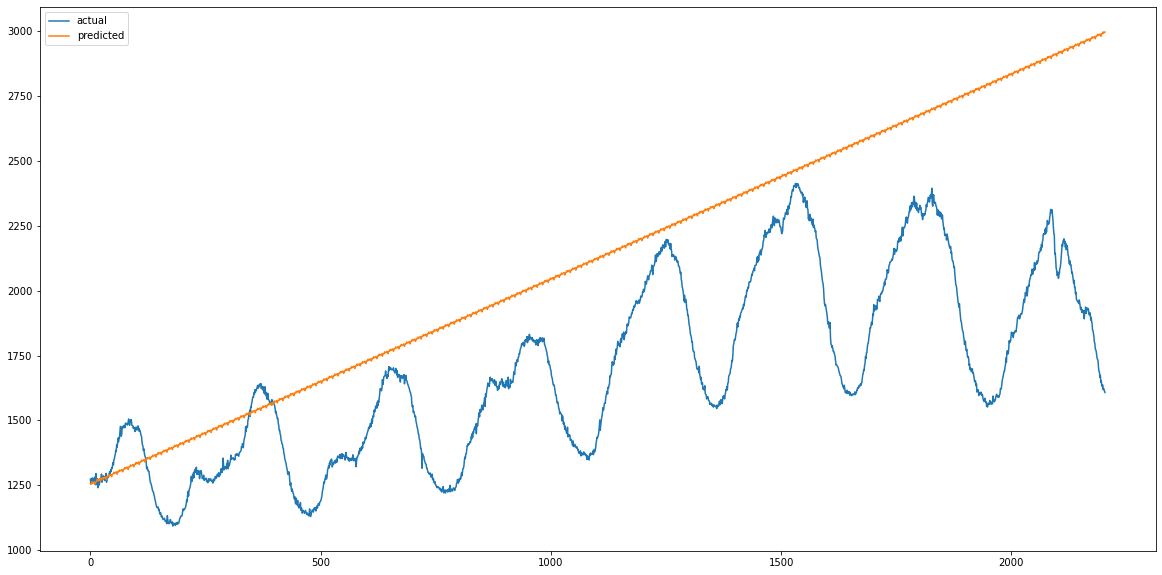

In [89]:
fig, ax = plt.subplots(figsize = (20,10))

# is there a way to not convert to pandas?
x = res.index.to_pandas()
y = res['actual'].to_pandas()
y2 = res['pred'].to_pandas()
plt.plot(x,y,label='actual')
plt.plot(x,y2,label='predicted')
ax.legend()

### AutoArima with cuML


In [46]:
# cuML has its own built in AutoArima functionality. the algorithm is capable inferring 
# the p,d, and q values 
from cuml.tsa.auto_arima import AutoARIMA

# replace with nyiso data set*****
auto_pop = AutoARIMA(train, simple_differencing = True)

In [47]:
%%time
auto_pop.search(s=0, d=(0, 1), D=(0, 1), p=(0, 2, 4), q=(0, 2, 4),P=range(2), Q=range(2))
auto_pop.fit()

[I] [00:08:16.784521] Deciding D...
[I] [00:08:16.784649] Deciding d...
[I] [00:08:16.786715] Deciding p, q, P, Q, k...
[I] [00:08:23.454188] Finalizing...
CPU times: user 6.21 s, sys: 2.08 s, total: 8.29 s
Wall time: 8.3 s


In [48]:
%%time
# Predict in-sample and forecast out-of-sample
auto_pred = auto_pop.predict(92, 136)
auto_pred = [float(item) for sublist in auto_pred for item in sublist]
auto_pred

CPU times: user 7.6 ms, sys: 20.5 ms, total: 28.1 ms
Wall time: 27.6 ms


[23734.320155104775,
 26001.227719602022,
 30859.14255852667,
 32716.161311549033,
 28280.318205574647,
 25621.123696562587,
 30120.084813298396,
 30800.522004703358,
 24420.726964309488,
 25528.466370843475,
 29638.03860845932,
 33014.91981828031,
 23977.17384234862,
 25385.026927412433,
 31077.25088951984,
 32645.235588201806,
 26441.503979666835,
 24408.02916324427,
 29254.59450992831,
 30062.292354423396,
 23020.587260158783,
 24378.7350927151,
 28045.580113160635,
 30509.26322235624,
 22546.70328328794,
 24513.604619398597,
 29694.00346483176,
 31126.69966851251,
 26418.946642903124,
 23086.376261246365,
 27602.960644547704,
 29735.52887350504,
 24028.98899616683,
 24182.86753222259,
 28509.99884876816,
 30431.23350271469,
 22217.27951775045,
 24668.16819225193,
 29246.92244878177,
 31692.54050721474,
 25284.49330846544,
 25576.08905911022,
 30259.509459212128,
 31968.25718016672]

In [49]:
res = cudf.DataFrame()
res['pred'] = auto_pred
res['actual'] = test

# As you can see, the performance is roughly similar to the cpu version
print(cuml.metrics.regression.mean_squared_error(test, res['pred'], squared = False))
res

5075.029910800363


,pred,actual
0,23734.320155,16052.0
1,26001.227720,22146.0
2,30859.142559,21198.0
3,32716.161312,19543.0
4,28280.318206,22084.0
5,25621.123697,23816.0
6,30120.084813,29961.0
7,30800.522005,26773.0
8,24420.726964,26635.0
9,25528.466371,26972.0


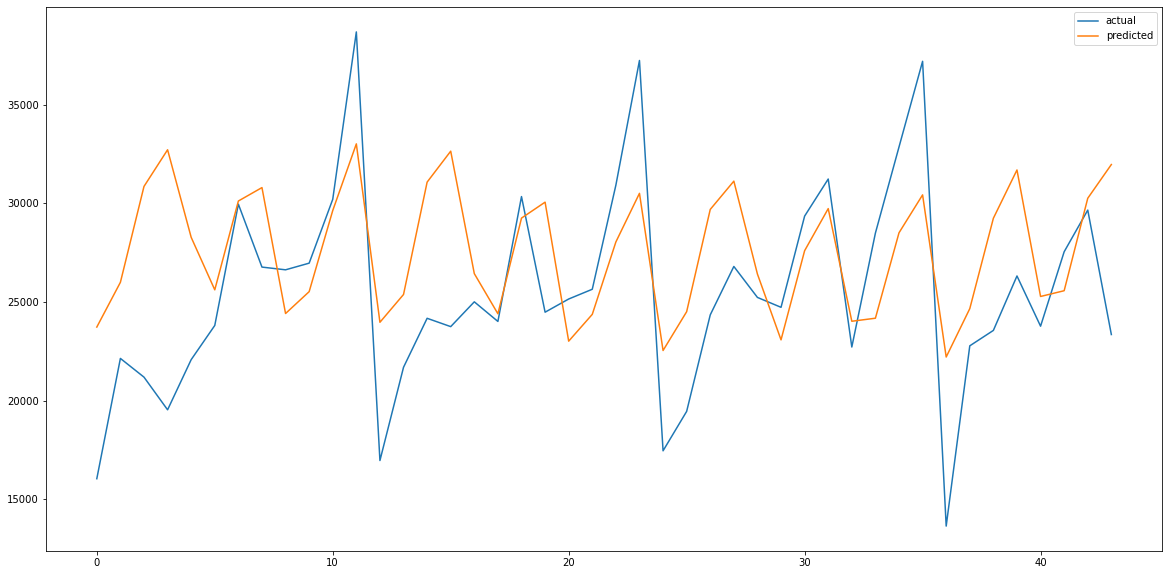

In [50]:
fig, ax = plt.subplots(figsize = (20,10))

# is there a way to not convert to pandas?
x = res.index.to_pandas()
y = res['actual'].to_pandas()
y2 = res['pred'].to_pandas()
plt.plot(x,y,label='actual')
plt.plot(x,y2,label='predicted')
ax.legend()

### cuML: HoltWinters

In [51]:
from cuml import ExponentialSmoothing


# this is a dataset from R
wineind = load_wineind().astype(np.float64)
# training and test sets
train = wineind[:132]
test = wineind[132:]

data = cudf.Series(train)


cu_hw = ExponentialSmoothing(data, seasonal_periods=12)
cu_hw.fit()
cu_pred = cu_hw.forecast(44)

print('Forecasted points:', cu_pred)
test[:44]

print(cuml.metrics.regression.mean_squared_error(test, cu_pred, squared = False))
# it outperformed auto arima! 

Forecasted points: 0     15261.293625
1     18317.401977
2     24052.499856
3     29259.013013
4     21645.218006
5     21264.833045
6     27911.499214
7     24813.894698
8     24143.552089
9     25364.703274
10    31449.966400
11    35300.724416
12    14800.679699
13    17856.788051
14    23591.885931
15    28798.399087
16    21184.604081
17    20804.219119
18    27450.885288
19    24353.280772
20    23682.938163
21    24904.089348
22    30989.352474
23    34840.110490
24    14340.065773
25    17396.174125
26    23131.272005
27    28337.785162
28    20723.990155
29    20343.605193
30    26990.271362
31    23892.666846
32    23222.324237
33    24443.475422
34    30528.738548
35    34379.496564
36    13879.451847
37    16935.560199
38    22670.658079
39    27877.171236
40    20263.376229
41    19882.991267
42    26529.657437
43    23432.052921
dtype: float64
3394.306240066547


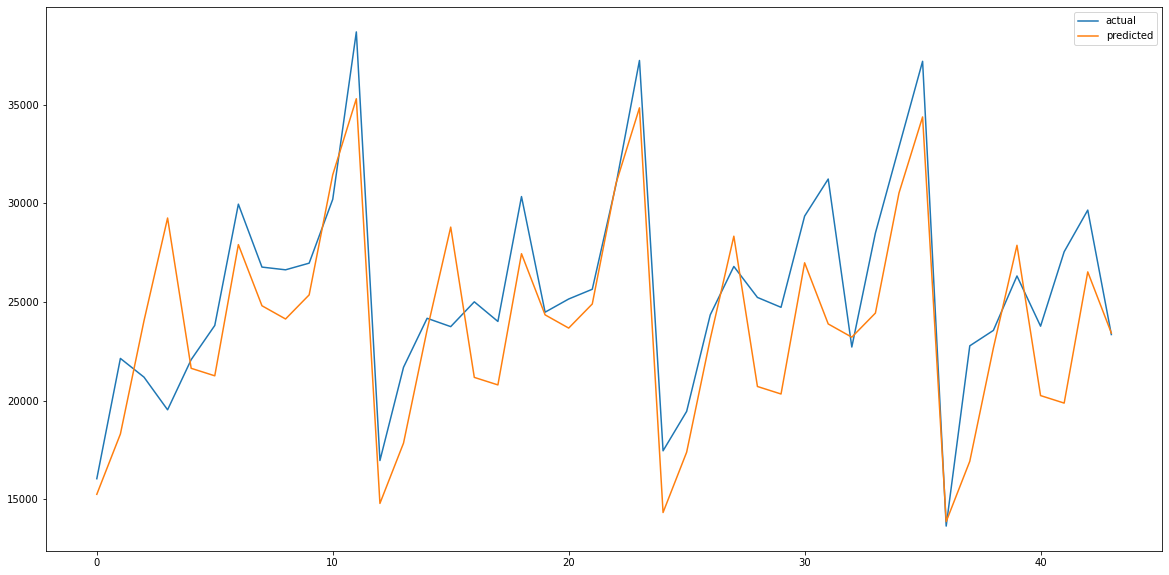

In [54]:
fig, ax = plt.subplots(figsize = (20,10))

# is there a way to not convert to pandas?
x = pd.Series(test).index
y = test
y2 = cu_pred.to_pandas()
plt.plot(x,y,label='actual')
plt.plot(x,y2,label='predicted')
ax.legend()